# Incremental Analysis of a Shallow Arch

![Shallow arch](./images/ClarkeHancock.png)

> Clarke, M.J. and Hancock, G.J. (1990) ‘A study of incremental‐iterative strategies for non‐linear analyses’, International Journal for Numerical Methods in Engineering, 29(7), pp. 1365–1391. Available at: https://doi.org/10.1002/nme.1620290702.


In [1]:
from arch import arch_model
import numpy as np
import opensees.openseespy


In [2]:
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
# from arch_model import arch_model

plt.style.use(["science", "notebook"])

<dl>
<dt>Solution 1</dt><dd>
Iterative strategy: Constant load (Section 3.1)
Load incrementation strategy: Direct incrementation of the load parameter (Section 4.1.1)
</dd>
<dt>Solution 2</dt><dd>
Iterative strategy: Constant vertical displacement under the load, $v_6$ (Section 3.2)
Load incrementation strategy: Incrementation of the displacement component $v_6$ (Section 4.1.2)
</dd>
<dt>Solution 3</dt><dd>
Iterative strategy: Constant arc-length (Section 3.3)
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 4</dt><dd>
Iterative strategy: Minimum unbalanced displacement norm (Section 3.5)
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 5</dt><dd>
Iterative strategy: Constant weighted response (Section 3.7, equation (39))
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 6</dt><dd>
Iterative strategy: Minimum unbalanced force norm (Section 3.6)
Load incrementation strategy: Using the current stiffness parameter (Section 4.2, equation (57))
</dd>
<dt>Solution 7</dt><dd>
Iterative strategy: Minimum unbalanced force norm (Section 3.6)
Load incrementation strategy: Incrementation of the arc-length (Section 4.1.3)
</dd>
<dt>Solution 8</dt><dd>
Iterative strategy: Constant arc-length (Section 3.3)
Load incrementation strategy: Using the current stiffness parameter (Section 4.2, equation (57))
</dd>
</dl>

In [3]:

def analyze(model, mid, dof, incr, steps):
    model.algorithm("Newton")
    xy = []
    for i in range(steps):
        incr(model, mid, dof)
        status = model.analyze(1)
        # return if analysis failed
        if status != 0:
            break
        xy.append([model.nodeDisp(mid, dof), model.getTime()])
    return np.array(xy)


def solution0(model, mid, steps):
    """
    """
    dof = 2
    model.algorithm("Newton")
    model.integrator("LoadControl", 400.0)
    model.analysis("Static")
    
    return np.array([
        [model.analyze(1) or model.nodeDisp(mid, dof), model.getTime()] for i in range(steps)
    ])

def solution1(model, mid, steps):
    """
    """
    Jd = 15
    dof = 2
    model.algorithm("Newton")
    model.integrator("LoadControl", 400.0, Jd, -800., 800.)
    model.analysis("Static")

    return np.array([
        [model.analyze(1) or model.nodeDisp(mid, dof), model.getTime()] for i in range(steps)
    ])

def solution2(model, mid, steps, dx):
    Jd  = 5
    dof = 2
    model.algorithm("Newton")
    model.integrator("DisplacementControl", mid, dof, dx, Jd)
    model.analysis("Static")
    return np.array([
        [model.analyze(1) or model.nodeDisp(mid, dof), model.getTime()] for i in range(steps)
    ])

def norm_control(model, mid, steps):
    dof = 2
    Jd = 15
    model.algorithm("Newton")
    model.integrator("MinUnbalDispNorm",  1.0, Jd, -10, 10)
    model.analysis("Static")
    return np.array([
        [model.analyze(1) or model.nodeDisp(mid, dof), model.getTime()] for i in range(steps)
    ])

def arc_control(model, mid, steps):
    dof = 2
    model.algorithm("ModifiedNewton")
    model.integrator("ArcLength",  1.0, 0)
    model.analysis("Static")
    return np.array([
        [model.analyze(1) or model.nodeDisp(mid, dof), model.getTime()] for i in range(steps)
    ])

def solutionX(model, mid, steps, gamma=0.8):
    model.algorithm("Newton")
    model.analysis("Static")
    output = []

    output.append([
        0, model.nodeDisp(mid,2)
    ])

    for i in range(steps):
        model.integrator("DisplacementControl", mid, 2, -0.1, niter, -0.1, -0.001)
        model.analyze(1)

    return np.array([
        [model.getTime(), model.analyze(1) or model.nodeDisp(mid, 2)] for i in range(steps)
    ])

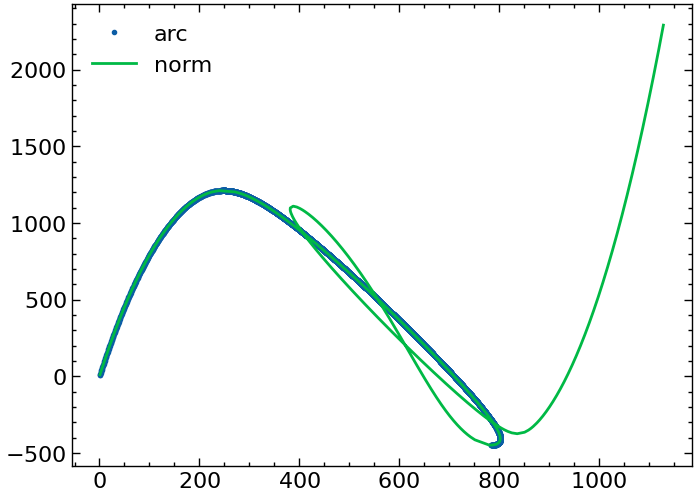

In [4]:
# x, y = solution0(*arch_model(), 6).T
# plt.plot(-x, y, 'x', label="S0")

# x, y = solution1(*arch_model(), 6).T
# plt.plot(-x, y, ':', label="S1")
# print(y)

# x, y = solution2(*arch_model(), 7, -150).T
# plt.plot(-x, y, 'o', label="S2")

# x, y = solution2(*arch_model(), 600, -1.5).T
# plt.plot(-x, y, '-', label="S2")

x, y = arc_control(*arch_model(), 5000).T
plt.plot(-x, y, ".", label="arc")

x, y = norm_control(*arch_model(), 8000).T
plt.plot(-x, y, label="norm")

plt.legend()

In [5]:
model, x = arch_model()

In [6]:
model.nodeDisp(x, 2)

0.0

In [7]:
model.integrator("LoadControl", 400)